# 2/1/17

`FEProblemBase::reinitMaterials` only calls property computation for Material objects currently active on the given subdomain so that's good. However, it's possible that material objects "active" on the subdomain aren't actually being used in any computing objects like kernels, etc. So we would like to do some additional checking.

Alright, let's say we're computing the residual thread. Then assuming we cannot compute properties in a material in isolation, we would like to do the next best thing: only call `computeQpProperties` for materials that have actually been asked to supply properties to kernels, dg_kernels, boundary_conditions, and interface_kernels. 

So what am I doing as of commit d7dbfe5? I am determining the `needed_mat_props` through `ComputeResidualThread::subdomainChanged()` -> `FEProblemBase::prepareMaterials`. In the latter method, we first ask all materials--if there are _any_ materials active on the block--to  update their material property dependencies and then we ask materials on the boundaries of the subdomain to also update their dependencies. Note that this could lead to a boundary material object getting asked to update their material property dependencies twice because we first pass to `MaterialWarehouse::updateMatPropDependenceyHelper` all material objects as long as there is any one material object active in a block sense on the subdomain, and then we pass active material boundary objects. But this overlap doesn't matter so much because our `needed_mat_props` is a set, so if we try to insert the same material properties multiple times, it will silently and correctly fail. Note,  however, that this could also pass `needed_mat_props` from material objects not on the current block, so that needs to be changed.

So what happens in `MaterialWarehouse::updateMatPropDependencyHelper`? We add `mp_deps` from `MaterialPropertyInterface::getMatPropDependencies`. However, it should be noted that this is only done for  <i>material objects</i>. Is this fine? Well let's figure it out. It returns `_material_property_dependencies` which is a set added to by calling `addMatPropDependency`. Now this gets called when the object that inherits from `MaterialPropertyInterface` calls its own `getMaterialProperty` method. So I hypothesize that in my simple test, if I ask to have a material property in my kernel object with `getMaterialProperty` that will not register in any material objects list of `_material_property_dependencies` and consequently `computeQpProperties` will never get called. I will test that the next time I sit down at my comp.

# 2/2/17

Three tests:

- Run with _one_ material that doesn't supply any properties. Desired behavior: `computeQpProperties` does not get called. Expected to **Pass**. With devel MOOSE: expected to **Fail** (expected **change**)
- Run _two_ materials, one that supplies properties, another that does not. Desired behavior: `computeQpProperties` does not get called for the material not supplying properties while the other one does. Expected behavior:  both materials compute methods get called. **Fail**. With devel MOOSE: expected to **Fail** (expected to **not change**)
- Run with a kernel that uses a material property and an elemental aux variable that does not. Desired behavior: `computeQpProperties` should get called through the residual and jacobian threads but not through the aux kernel thread. Expected  to **Pass**. With devel MOOSEE: expected to **Fail** (expected **change**)

Calls to computeProperties:

1. ComputeResidualThread
2. ComputeResidualThread
0th nonlinear residual printed
3. ComputeJacobianThread
4. ComputeResidualThread
0th linear residual printed
5. ComputeResidualThread
1st linear residual printed
6. ComputeResidualThread
7. ComputeResidualThread
1st nonlinear residual printed
8. ComputeElemAuxVarsThread -> Actually this is fine because this is the Aux Kernel that is created for outputting the material property

Number of calls: 8
1. 1-4
2. 5-8
...
7. 25-28
8. 29-32

Failed tests:

- random.material_serial
- controls\*

Failed but now passing:

- element\_aux\_boundary
- bnd\_material\_test
- elem\_aux\_bc\_on\_bound
- output.boundary
- multiplicity
- material_point_source_test
- line\_material\_sampler

# 2/6/17

Ok my new test is failing with threads and I don't really know why. It seems like the number of calls to computing threads should be the same...

Calls to computeProperties:

1. ComputeResidualThread
2. ComputeResidualThread
0th nonlinear residual printed
3. ComputeJacobianThread
4. ComputeResidualThread
0th linear residual printed
5. ComputResidualThread
1st linear residual printed
6. ComputeResidualThread
7. ComputeResidualThread
1st nonlinear residual printed
8. ComputeElemAuxVarsThread

Yep so thread computing pattern is the exact same. How about whether the material is the same location in memory every time?

- 0x7fed90 (1, 2, 8)
Increments:
1-4, 5-8, 9-12 -> average of 10.5 which is what is observed in the output
- 0x810b10 (3, 4, 5, 6, 7

# 4/28/17

Navier Stokes module development

In [2]:
import sympy as sp

sxx, sxy, syx, syy, nx, ny = sp.var('sxx sxy syx syy nx ny')

In [5]:
s = sp.Matrix([[sxx, sxy],[syx, syy]])
n = sp.Matrix([nx, ny])

In [6]:
s*n

Matrix([
[nx*sxx + ny*sxy],
[nx*syx + ny*syy]])

In [14]:
prod = n.transpose()*s*n
prod2 = n.transpose()*(s*n)

In [15]:
print(prod)
print(prod2)
print(prod==prod2)

Matrix([[nx*(nx*sxx + ny*syx) + ny*(nx*sxy + ny*syy)]])
Matrix([[nx*(nx*sxx + ny*sxy) + ny*(nx*syx + ny*syy)]])
False


In [13]:
prod.shape

(1, 1)

In [18]:
sp.expand(prod) == sp.expand(prod2)

True

In [20]:
lhs = n.transpose()*s
print(lhs.shape)

(1, 2)


In [21]:
rhs = (n.transpose() * s * n) * n.transpose()
print(rhs.shape)

(1, 2)


In [62]:
rhs2 = (n.transpose()*s) * (n*n.transpose())
print(rhs2)
rhs3 = n.transpose() * (s*n*n.transpose())
print(sp.expand(rhs) == sp.expand(rhs2) == sp.expand(rhs3))

Matrix([[nx**2*(nx*sxx + ny*syx) + nx*ny*(nx*sxy + ny*syy), nx*ny*(nx*sxx + ny*syx) + ny**2*(nx*sxy + ny*syy)]])
True


In [58]:
print(n*n.transpose())

Matrix([[nx**2, nx*ny], [nx*ny, ny**2]])


In [59]:
print(n.transpose()*n)

Matrix([[nx**2 + ny**2]])


In [48]:
print(sp.simplify(lhs))
print(sp.simplify(rhs))

Matrix([[nx*sxx + ny*syx, nx*sxy + ny*syy]])
Matrix([[nx*(nx*(nx*sxx + ny*syx) + ny*(nx*sxy + ny*syy)), ny*(nx*(nx*sxx + ny*syx) + ny*(nx*sxy + ny*syy))]])


In [27]:
elml = lhs[0,0]
elmr = rhs[0,0]

In [29]:
print(elml.expand())
print(elmr.expand())

nx*sxx + ny*syx
nx**3*sxx + nx**2*ny*sxy + nx**2*ny*syx + nx*ny**2*syy


In [43]:
elmr.expand()

nx**3*sxx + nx**2*ny*sxy + nx**2*ny*syx + nx*ny**2*syy

In [42]:
elmr.expand().subs(nx, sp.sqrt(1 - ny**2))

ny**2*syy*sqrt(-ny**2 + 1) + ny*sxy*(-ny**2 + 1) + ny*syx*(-ny**2 + 1) + sxx*(-ny**2 + 1)**(3/2)

In [44]:
elmr.expand().subs(nx, sp.sqrt(1 - ny**2)).simplify()

ny**2*syy*sqrt(-ny**2 + 1) - ny*sxy*(ny**2 - 1) - ny*syx*(ny**2 - 1) + sxx*(-ny**2 + 1)**(3/2)

In [36]:
help(expr.replace)

Help on method replace in module sympy.core.basic:

replace(query, value, map=False, simultaneous=True, exact=False) method of sympy.core.add.Add instance
    Replace matching subexpressions of ``self`` with ``value``.
    
    If ``map = True`` then also return the mapping {old: new} where ``old``
    was a sub-expression found with query and ``new`` is the replacement
    value for it. If the expression itself doesn't match the query, then
    the returned value will be ``self.xreplace(map)`` otherwise it should
    be ``self.subs(ordered(map.items()))``.
    
    Traverses an expression tree and performs replacement of matching
    subexpressions from the bottom to the top of the tree. The default
    approach is to do the replacement in a simultaneous fashion so
    changes made are targeted only once. If this is not desired or causes
    problems, ``simultaneous`` can be set to False. In addition, if an
    expression containing more than one Wild symbol is being used to match
   

In [49]:
t = lhs - rhs
print(t)

Matrix([[nx*sxx - nx*(nx*(nx*sxx + ny*syx) + ny*(nx*sxy + ny*syy)) + ny*syx, nx*sxy + ny*syy - ny*(nx*(nx*sxx + ny*syx) + ny*(nx*sxy + ny*syy))]])


In [51]:
t1 = t[0,0]
t2 = t[0,1]

In [52]:
print(t1)
print(t2)

nx*sxx - nx*(nx*(nx*sxx + ny*syx) + ny*(nx*sxy + ny*syy)) + ny*syx
nx*sxy + ny*syy - ny*(nx*(nx*sxx + ny*syx) + ny*(nx*sxy + ny*syy))


In [53]:
t1.simplify()

nx*sxx - nx*(nx*(nx*sxx + ny*syx) + ny*(nx*sxy + ny*syy)) + ny*syx

In [63]:
ddx, ddy, ux, uy = sp.var('ddx ddy ux uy')

grad = sp.Matrix([ddx,ddy])
u = sp.Matrix([ux,uy])
print(grad.shape)

phij,mu = sp.var('phij mu')
uDuxj = sp.Matrix([phij,0])

uDuyj = sp.Matrix([0,phij])

In [65]:
grad*u.transpose()

Matrix([
[ddx*ux, ddx*uy],
[ddy*ux, ddy*uy]])

In [78]:
jacx = n.transpose() * (mu * (grad*uDuxj.transpose() + (grad*uDuxj.transpose()).transpose())) * n
print(jacx)

Matrix([[ddy*mu*nx*ny*phij + nx*(2*ddx*mu*nx*phij + ddy*mu*ny*phij)]])


In [79]:
sp.expand(jacx[0,0])*nx

nx*(2*ddx*mu*nx**2*phij + 2*ddy*mu*nx*ny*phij)

In [81]:
jacy = n.transpose() * (mu * (grad*uDuyj.transpose() + (grad*uDuyj.transpose()).transpose())) * n
print(jacy)

Matrix([[ddx*mu*nx*ny*phij + ny*(ddx*mu*nx*phij + 2*ddy*mu*ny*phij)]])


In [82]:
sp.expand(jacy[0,0])*ny

ny*(2*ddx*mu*nx*ny*phij + 2*ddy*mu*ny**2*phij)

In [83]:
sp.factor(jacy[0,0])

2*mu*ny*phij*(ddx*nx + ddy*ny)

In [87]:
print(sp.factor((jacx[0,0]*n.transpose())[0,0]))
print(sp.factor((jacy[0,0]*n.transpose())[0,1]))

2*mu*nx**2*phij*(ddx*nx + ddy*ny)
2*mu*ny**2*phij*(ddx*nx + ddy*ny)


In [88]:
sJacX = mu * (grad*uDuxj.transpose() + (grad*uDuxj.transpose()).transpose())
sJacY = mu * (grad*uDuyj.transpose() + (grad*uDuyj.transpose()).transpose())
print(sJacX)
print(sJacY)

Matrix([[2*ddx*mu*phij, ddy*mu*phij], [ddy*mu*phij, 0]])
Matrix([[0, ddx*mu*phij], [ddx*mu*phij, 2*ddy*mu*phij]])


In [90]:
print(sp.factor((n.transpose()*sJacX)[0,0]))
print(sp.factor((n.transpose()*sJacY)[0,1]))

mu*phij*(2*ddx*nx + ddy*ny)
mu*phij*(ddx*nx + 2*ddy*ny)


In [85]:
jacx.shape

(1, 1)

# Jacobian calculations related to deviatoric stress tensor ($\hat{\tau}$) and rate of strain tensor ($\hat{\epsilon}$)

**Note that the total stress tensor ($\hat{\sigma}$) is equal to the sum of the deviatoric stress tensor ($\hat{\tau}$) and the stress induced by pressure ($-p\hat{I}$), e.g.**

\begin{equation}
\hat{\sigma} = \hat{\tau} - p\hat{I}
\end{equation}

In [5]:
import sympy as sp

sxx, sxy, syx, syy, nx, ny, mu = sp.var('sxx sxy syx syy nx ny mu')
ddx, ddy, ux, uy = sp.var('ddx ddy ux uy')

grad = sp.Matrix([ddx,ddy])
u = sp.Matrix([ux,uy])

phij,mu = sp.var('phij mu')
uDuxj = sp.Matrix([phij,0])
uDuyj = sp.Matrix([0,phij])

rateOfStrain = (grad*u.transpose() + (grad*u.transpose()).transpose()) * 1 / 2
d_rateOfStrain_d_uxj = (grad*uDuxj.transpose() + (grad*uDuxj.transpose()).transpose()) * 1 / 2
d_rateOfStrain_d_uyj = (grad*uDuyj.transpose() + (grad*uDuyj.transpose()).transpose()) * 1 / 2
print(rateOfStrain)
print(d_rateOfStrain_d_uxj)
print(d_rateOfStrain_d_uyj)

Matrix([[ddx*ux, ddx*uy/2 + ddy*ux/2], [ddx*uy/2 + ddy*ux/2, ddy*uy]])
Matrix([[ddx*phij, ddy*phij/2], [ddy*phij/2, 0]])
Matrix([[0, ddx*phij/2], [ddx*phij/2, ddy*phij]])


In [7]:
tau = rateOfStrain * 2 * mu
d_tau_d_uxj = d_rateOfStrain_d_uxj * 2 * mu
d_tau_d_uyj = d_rateOfStrain_d_uyj * 2 * mu
print(tau)
print(d_tau_d_uxj)
print(d_tau_d_uyj)

Matrix([[2*ddx*mu*ux, mu*(ddx*uy + ddy*ux)], [mu*(ddx*uy + ddy*ux), 2*ddy*mu*uy]])
Matrix([[2*ddx*mu*phij, ddy*mu*phij], [ddy*mu*phij, 0]])
Matrix([[0, ddx*mu*phij], [ddx*mu*phij, 2*ddy*mu*phij]])


In [10]:
normals = sp.Matrix([nx,ny])
y_component_normal = sp.Matrix([0,ny])
x_component_normal = sp.Matrix([nx,0])
test = sp.var('test')
test_x = sp.Matrix([test,0])
test_y = sp.Matrix([0,test])

## This is an example of an **off-diagonal** jacobian computation: derivative with respect to $x$ while test function corresponds to $y$

### Specifically this corresponds to an off-diagonal contribution corresponding to the residual term:

\begin{equation}
\vec{n}^T \cdot \hat{\tau} \cdot \vec{v}_y
\end{equation}

In [12]:
normals.transpose() * d_tau_d_uxj * test_y

Matrix([[ddy*mu*nx*phij*test]])

### Now let's look at an off diagonal-term for:

\begin{equation}
\left(\vec{n}^T \cdot \hat{\tau} \cdot \vec{n} \right) \vec{n}^T \cdot \vec{v}_y
\end{equation}

In [14]:
sp.factor(normals.transpose() * d_tau_d_uxj * normals * normals.transpose() * test_y)

Matrix([[2*mu*nx*ny*phij*test*(ddx*nx + ddy*ny)]])

## Hmm...that's not very revealing...this result is completely symmetric...it doesn't tell me what the code implementation should be. Let's try 3D in order to elucidate

In [3]:
import sympy as sp

nx, ny, nz, mu, phij, ddx, ddy, ddz, ux, uy, uz = sp.var('nx ny nz mu phij ddx ddy ddz ux uy uz')
grad = sp.Matrix([ddx,ddy,ddz])
u = sp.Matrix([ux, uy, uz])
uDuxj = sp.Matrix([phij,0,0])
uDuyj = sp.Matrix([0,phij,0])
uDuzj = sp.Matrix([0,0,phij])

rateOfStrain = (grad*u.transpose() + (grad*u.transpose()).transpose()) * 1 / 2
d_rateOfStrain_d_uxj = (grad*uDuxj.transpose() + (grad*uDuxj.transpose()).transpose()) * 1 / 2
d_rateOfStrain_d_uyj = (grad*uDuyj.transpose() + (grad*uDuyj.transpose()).transpose()) * 1 / 2
d_rateOfStrain_d_uzj = (grad*uDuzj.transpose() + (grad*uDuzj.transpose()).transpose()) * 1 / 2
print(rateOfStrain)
print(d_rateOfStrain_d_uxj)
print(d_rateOfStrain_d_uyj)
print(d_rateOfStrain_d_uzj)

Matrix([[ddx*ux, ddx*uy/2 + ddy*ux/2, ddx*uz/2 + ddz*ux/2], [ddx*uy/2 + ddy*ux/2, ddy*uy, ddy*uz/2 + ddz*uy/2], [ddx*uz/2 + ddz*ux/2, ddy*uz/2 + ddz*uy/2, ddz*uz]])
Matrix([[ddx*phij, ddy*phij/2, ddz*phij/2], [ddy*phij/2, 0, 0], [ddz*phij/2, 0, 0]])
Matrix([[0, ddx*phij/2, 0], [ddx*phij/2, ddy*phij, ddz*phij/2], [0, ddz*phij/2, 0]])
Matrix([[0, 0, ddx*phij/2], [0, 0, ddy*phij/2], [ddx*phij/2, ddy*phij/2, ddz*phij]])


In [4]:
tau = rateOfStrain * 2 * mu
d_tau_d_uxj = d_rateOfStrain_d_uxj * 2 * mu
d_tau_d_uyj = d_rateOfStrain_d_uyj * 2 * mu
d_tau_d_uzj = d_rateOfStrain_d_uzj * 2 * mu
print(tau)
print(d_tau_d_uxj)
print(d_tau_d_uyj)
print(d_tau_d_uzj)

Matrix([[2*ddx*mu*ux, mu*(ddx*uy + ddy*ux), mu*(ddx*uz + ddz*ux)], [mu*(ddx*uy + ddy*ux), 2*ddy*mu*uy, mu*(ddy*uz + ddz*uy)], [mu*(ddx*uz + ddz*ux), mu*(ddy*uz + ddz*uy), 2*ddz*mu*uz]])
Matrix([[2*ddx*mu*phij, ddy*mu*phij, ddz*mu*phij], [ddy*mu*phij, 0, 0], [ddz*mu*phij, 0, 0]])
Matrix([[0, ddx*mu*phij, 0], [ddx*mu*phij, 2*ddy*mu*phij, ddz*mu*phij], [0, ddz*mu*phij, 0]])
Matrix([[0, 0, ddx*mu*phij], [0, 0, ddy*mu*phij], [ddx*mu*phij, ddy*mu*phij, 2*ddz*mu*phij]])


In [5]:
normals = sp.Matrix([nx,ny,nz])
test = sp.var('test')
test_x = sp.Matrix([test,0,0])
test_y = sp.Matrix([0,test,0])
test_z = sp.Matrix([0,0,test])

In [21]:
sp.factor(normals.transpose() * d_tau_d_uxj * normals * normals.transpose() * test_y)

Matrix([[2*mu*nx*ny*phij*test*(ddx*nx + ddy*ny + ddz*nz)]])

In [22]:
sp.factor(normals.transpose() * d_tau_d_uxj * normals * normals.transpose() * test_z)

Matrix([[2*mu*nx*nz*phij*test*(ddx*nx + ddy*ny + ddz*nz)]])

In [23]:
sp.factor(normals.transpose() * d_tau_d_uyj * normals * normals.transpose() * test_x)

Matrix([[2*mu*nx*ny*phij*test*(ddx*nx + ddy*ny + ddz*nz)]])

## Alright, it looks like we get the normal components corresponding to residual $i$ and derivative variable $j$!!! Boom!

In [7]:
(normals.transpose() * tau)[0]

2*ddx*mu*nx*ux + mu*ny*(ddx*uy + ddy*ux) + mu*nz*(ddx*uz + ddz*ux)

In [9]:
sp.factor(_)

mu*(2*ddx*nx*ux + ddx*ny*uy + ddx*nz*uz + ddy*ny*ux + ddz*nz*ux)

# 5/3/17

In [30]:
from scipy.special import erf
from numpy import exp, sqrt, pi
import numpy as np

def u(x, y, u1, u2, sigma):
    return (u1 + u2) / 2. - (u1 - u2) / 2. * erf(sigma * y / x)

def v(x, y, u1, u2, sigma):
    return (u1 - u2) / (2. * sigma * sqrt(pi)) * exp(-(sigma * y / x)**2)

def p():
    return 0

def k(x, y, k0, sigma):
    return k0 * exp(-(sigma * y / x)**2)

def epsilon(x, y, epsilon0, sigma):
    return epsilon0 / x * exp(-(sigma * y / x)**2)

def muT(x, y, muT0, sigma):
    return muT0 * x * exp(-(sigma * y / x)**2)

def k0(u1, u2, sigma):
    return 343. / 75000. * u1 * (u1 - u2) * sigma / sqrt(pi)

def epsilon0(u1, u2, sigma, Cmu):
    return 343. / 22500. * Cmu * u1 * (u1 - u2)**2 * sigma**2 / pi

def muT0(u1, rho):
    return 343. / 250000. * rho * u1

def Re(rho, u1, L, mu):
    return rho * u1 * L / mu

u1 = 1
u2 = 0
sigma = 13.5
Cmu = 0.9
x = np.arange(10, 100.5, .5)
y = np.arange(-30, 30.5, .5)
x,y = np.meshgrid(x, y)
uplot = u(x, y, u1, u2, sigma)
vplot = v(x, y, u1, u2, sigma)
kplot = k(x, y, k0(u1, u2, sigma), sigma)
epsPlot = epsilon(x, y, epsilon0(u1, u2, sigma, Cmu), sigma)
muTplot = muT(x, y, muT0(u1, 1), sigma)

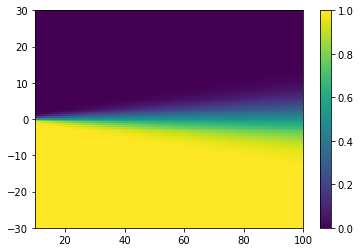

In [25]:
import matplotlib.pyplot as plt

plt.pcolor(x, y, uplot)
plt.colorbar()
plt.show()

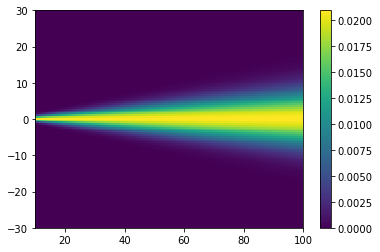

In [27]:
plt.pcolor(x, y, vplot)
plt.colorbar()
plt.show()

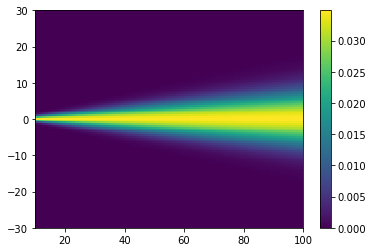

In [28]:
plt.pcolor(x, y, kplot)
plt.colorbar()
plt.show()

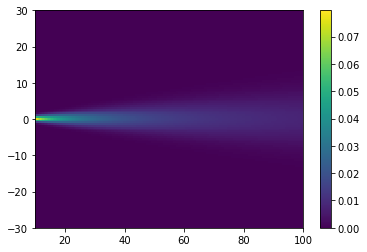

In [29]:
plt.pcolor(x, y, epsPlot)
plt.colorbar()
plt.show()

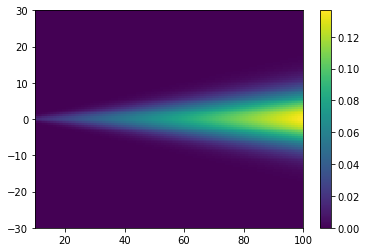

In [31]:
plt.pcolor(x, y, muTplot)
plt.colorbar()
plt.show()

In [1]:
import sympy as sp
from sympy import diff

x, y, sigma, Cmu, rho, mu, k0, eps0 = sp.var('x y sigma Cmu rho mu k0 eps0')

In [2]:
def gradVec2(u_vec, x, y):
    return sp.Matrix([[diff(u_vec[0], x), diff(u_vec[1],x)], [diff(u_vec[0], y), diff(u_vec[1], y)]])

def divTen2(tensor, x, y):
    return sp.Matrix([diff(tensor[0,0], x) + diff(tensor[1,0], y), diff(tensor[0, 1], x) + diff(tensor[1,1], y)])

def divVec2(u_vec, x, y):
    return diff(u_vec[0], x) + diff(u_vec[1], y)

In [4]:
u = (1 - sp.erf(sigma * y / x)) / 2
v = sp.exp(-(sigma * y / x)**2) / 2 / sigma / sp.sqrt(sp.pi)
k = k0 * sp.exp(-(sigma * y / x)**2)
eps = eps0 / x * sp.exp(-(sigma * y / x)**2)
muT = rho * Cmu * k**2 / eps

u_vec = sp.Matrix([u, v])
grad_u_vec = gradVec2(u_vec, x, y)
visc_term = divTen2((mu + muT) * (grad_u_vec + grad_u_vec.transpose()), x, y)

In [5]:
print(sp.simplify(divVec2(u_vec, x, y)))

0


In [6]:
visc_term

Matrix([
[                   -2*Cmu*k0**2*rho*sigma**2*y*(-sigma*exp(-sigma**2*y**2/x**2)/(sqrt(pi)*x) + sigma*y**2*exp(-sigma**2*y**2/x**2)/(sqrt(pi)*x**3))*exp(-sigma**2*y**2/x**2)/(eps0*x) + 4*sigma**3*y**3*(Cmu*k0**2*rho*x*exp(-sigma**2*y**2/x**2)/eps0 + mu)*exp(-sigma**2*y**2/x**2)/(sqrt(pi)*x**5) + 2*sigma*y*(2*Cmu*k0**2*rho*sigma**2*y**2*exp(-sigma**2*y**2/x**2)/(eps0*x**2) + Cmu*k0**2*rho*exp(-sigma**2*y**2/x**2)/eps0)*exp(-sigma**2*y**2/x**2)/(sqrt(pi)*x**2) - 4*sigma*y*(Cmu*k0**2*rho*x*exp(-sigma**2*y**2/x**2)/eps0 + mu)*exp(-sigma**2*y**2/x**2)/(sqrt(pi)*x**3) + (Cmu*k0**2*rho*x*exp(-sigma**2*y**2/x**2)/eps0 + mu)*(2*sigma**3*y*exp(-sigma**2*y**2/x**2)/(sqrt(pi)*x**3) - 2*sigma**3*y**3*exp(-sigma**2*y**2/x**2)/(sqrt(pi)*x**5) + 2*sigma*y*exp(-sigma**2*y**2/x**2)/(sqrt(pi)*x**3))],
[4*Cmu*k0**2*rho*sigma**3*y**2*exp(-2*sigma**2*y**2/x**2)/(sqrt(pi)*eps0*x**3) + 4*sigma**3*y**2*(Cmu*k0**2*rho*x*exp(-sigma**2*y**2/x**2)/eps0 + mu)*exp(-sigma**2*y**2/x**2)/(sqrt(pi)*x**4) - 2*si

In [61]:
visc_term.shape

(2, 1)

In [7]:
momentum_equations = rho * u_vec.transpose() * grad_u_vec - visc_term.transpose()

In [12]:
u_eq = momentum_equations[0]
v_eq = momentum_equations[1]

In [16]:
sp.simplify(v_eq)

(-8*pi**5*Cmu*k0**2*rho*sigma**3*x**3*y**2 + 2*pi**5*Cmu*k0**2*rho*sigma*x*(x**2 - y**2)*(2*sigma**2*y**2 + x**2) - pi**5*eps0*rho*sigma*x**3*y**2*(erf(sigma*y/x) - 1)*exp(sigma**2*y**2/x**2) - pi**(9/2)*eps0*rho*x**4*y - 8*pi**5*sigma**3*x**2*y**2*(Cmu*k0**2*rho*x + eps0*mu*exp(sigma**2*y**2/x**2)) + 4*pi**5*sigma*x**4*(Cmu*k0**2*rho*x + eps0*mu*exp(sigma**2*y**2/x**2)) + 2*pi**5*sigma*(Cmu*k0**2*rho*x + eps0*mu*exp(sigma**2*y**2/x**2))*(-2*sigma**2*y**4 - x**4 + x**2*y**2*(2*sigma**2 + 3)))*exp(-2*sigma**2*y**2/x**2)/(2*pi**(11/2)*eps0*x**6)

In [13]:
sp.simplify(u_eq)

(-8*pi**3*Cmu*k0**2*rho*sigma**3*x**3*y - 8*pi**3*Cmu*k0**2*rho*sigma**3*x*y**3 - 4*pi**3*eps0*mu*sigma**3*x**2*y*exp(sigma**2*y**2/x**2) - 4*pi**3*eps0*mu*sigma**3*y**3*exp(sigma**2*y**2/x**2) + 4*pi**3*eps0*mu*sigma*x**2*y*exp(sigma**2*y**2/x**2) - pi**3*eps0*rho*sigma*x**3*y*exp(sigma**2*y**2/x**2)*erf(sigma*y/x) + pi**3*eps0*rho*sigma*x**3*y*exp(sigma**2*y**2/x**2) - pi**(5/2)*eps0*rho*x**4)*exp(-2*sigma**2*y**2/x**2)/(2*pi**(7/2)*eps0*x**5)

In [14]:
sp.collect(u_eq, x)

-4*sigma**3*y**3*(Cmu*k0**2*rho*x*exp(-sigma**2*y**2/x**2)/eps0 + mu)*exp(-sigma**2*y**2/x**2)/(sqrt(pi)*x**5) + 4*sigma*y*(Cmu*k0**2*rho*x*exp(-sigma**2*y**2/x**2)/eps0 + mu)*exp(-sigma**2*y**2/x**2)/(sqrt(pi)*x**3) - (Cmu*k0**2*rho*x*exp(-sigma**2*y**2/x**2)/eps0 + mu)*(2*sigma**3*y*exp(-sigma**2*y**2/x**2)/(sqrt(pi)*x**3) - 2*sigma**3*y**3*exp(-sigma**2*y**2/x**2)/(sqrt(pi)*x**5) + 2*sigma*y*exp(-sigma**2*y**2/x**2)/(sqrt(pi)*x**3)) + (2*Cmu*k0**2*rho*sigma**2*y*(-sigma*exp(-sigma**2*y**2/x**2)/(sqrt(pi)*x) + sigma*y**2*exp(-sigma**2*y**2/x**2)/(sqrt(pi)*x**3))*exp(-sigma**2*y**2/x**2)/eps0 - rho*exp(-2*sigma**2*y**2/x**2)/(2*pi))/x + (rho*sigma*y*(-erf(sigma*y/x)/2 + 1/2)*exp(-sigma**2*y**2/x**2)/sqrt(pi) - 2*sigma*y*(2*Cmu*k0**2*rho*sigma**2*y**2*exp(-sigma**2*y**2/x**2)/(eps0*x**2) + Cmu*k0**2*rho*exp(-sigma**2*y**2/x**2)/eps0)*exp(-sigma**2*y**2/x**2)/sqrt(pi))/x**2

In [10]:
u_eq = u_eq.subs(k0, sigma / sp.sqrt(sp.pi) * 343 / 75000)
print(u_eq)
u_eq = u_eq.subs(eps0, Cmu * sigma**2 / sp.pi * 343 / 22500)
print(u_eq)

117649*Cmu*rho*sigma**4*y*(-sigma*exp(-sigma**2*y**2/x**2)/(sqrt(pi)*x) + sigma*y**2*exp(-sigma**2*y**2/x**2)/(sqrt(pi)*x**3))*exp(-sigma**2*y**2/x**2)/(2812500000*pi*eps0*x) + rho*sigma*y*(-erf(sigma*y/x)/2 + 1/2)*exp(-sigma**2*y**2/x**2)/(sqrt(pi)*x**2) - rho*exp(-2*sigma**2*y**2/x**2)/(2*pi*x) - 4*sigma**3*y**3*(117649*Cmu*rho*sigma**2*x*exp(-sigma**2*y**2/x**2)/(5625000000*pi*eps0) + mu)*exp(-sigma**2*y**2/x**2)/(sqrt(pi)*x**5) - 2*sigma*y*(117649*Cmu*rho*sigma**4*y**2*exp(-sigma**2*y**2/x**2)/(2812500000*pi*eps0*x**2) + 117649*Cmu*rho*sigma**2*exp(-sigma**2*y**2/x**2)/(5625000000*pi*eps0))*exp(-sigma**2*y**2/x**2)/(sqrt(pi)*x**2) + 4*sigma*y*(117649*Cmu*rho*sigma**2*x*exp(-sigma**2*y**2/x**2)/(5625000000*pi*eps0) + mu)*exp(-sigma**2*y**2/x**2)/(sqrt(pi)*x**3) - (117649*Cmu*rho*sigma**2*x*exp(-sigma**2*y**2/x**2)/(5625000000*pi*eps0) + mu)*(2*sigma**3*y*exp(-sigma**2*y**2/x**2)/(sqrt(pi)*x**3) - 2*sigma**3*y**3*exp(-sigma**2*y**2/x**2)/(sqrt(pi)*x**5) + 2*sigma*y*exp(-sigma**2*y**2

In [11]:
sp.simplify(u_eq)

(-125000*pi**3*mu*sigma**3*x**2*y*exp(sigma**2*y**2/x**2) - 125000*pi**3*mu*sigma**3*y**3*exp(sigma**2*y**2/x**2) + 125000*pi**3*mu*sigma*x**2*y*exp(sigma**2*y**2/x**2) - 343*pi**3*rho*sigma**3*x**3*y - 343*pi**3*rho*sigma**3*x*y**3 - 31250*pi**3*rho*sigma*x**3*y*exp(sigma**2*y**2/x**2)*erf(sigma*y/x) + 31250*pi**3*rho*sigma*x**3*y*exp(sigma**2*y**2/x**2) - 31250*pi**(5/2)*rho*x**4)*exp(-2*sigma**2*y**2/x**2)/(62500*pi**(7/2)*x**5)

In [52]:
grad_u_vec = sp.Matrix([[diff(u, x), diff(v, x)], [diff(u, y), diff(v, y)]])

In [57]:
grad_u_vec

Matrix([
[sigma*y*exp(-sigma**2*y**2/x**2)/(sqrt(pi)*x**2), -y*exp(sigma*y/x)/(2*sqrt(pi)*x**2)],
[    -sigma*exp(-sigma**2*y**2/x**2)/(sqrt(pi)*x),       exp(sigma*y/x)/(2*sqrt(pi)*x)]])

In [40]:
clear(pi)

In [49]:
from sympy.physics.vector import ReferenceFrame
R = ReferenceFrame('R')

u = (1 - sp.erf(sigma * R[1] / R[0])) / 2
v = sp.exp(sigma * R[1] / R[0]) / 2 / sigma / sp.sqrt(pi)
k = k0 * sp.exp(-(sigma * R[1] / R[0])**2)
eps = eps0 / R[0] * sp.exp(-(sigma * R[1] / R[0])**2)
muT = rho * Cmu * k**2 / eps

In [50]:
u_vec[0]

-erf(sigma*y/x)/2 + 1/2

In [ ]:
grad_u_vec = gradVec2(u_vec)

In [18]:
from scipy.special import erf

erf(2)

0.99532226501895271

In [19]:
erf(-1)

-0.84270079294971478

In [20]:
erf(.99)

0.83850806955536983

In [47]:
from numpy import pi, sqrt, exp

def d_erf(x):
    return 2. / sqrt(pi) * exp(-x**2)

def d_half_erf(x):
    return 2. / sqrt(pi) * exp(-(0.5*x)**2) * 0.5

In [48]:
d_half_erf(-2)

0.20755374871029736

In [22]:
d_erf(-1)

0.41510749742059472

In [23]:
print(pi)

3.141592653589793


In [24]:
d_erf(0)

1.1283791670955126

In [25]:
d_erf(1)

0.41510749742059472

In [27]:
import numpy as np

In [28]:
libmesh = np.loadtxt("/home/lindsayad/projects/moose/libmesh/contrib/fparser/examples/first_orig.dat")

In [30]:
libmesh.shape

(200, 2)

In [42]:
xl = libmesh[:,0]
ypl = libmesh[:,1]

In [45]:
xt = np.arange(-1,1,.01)
yt = d_erf(xt)

In [33]:
import matplotlib.pyplot as plt

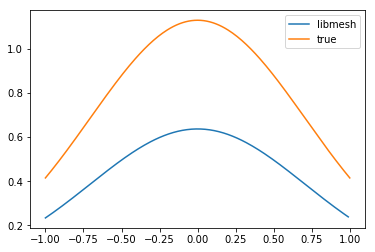

In [43]:
plt.close()
plt.plot(xl, ypl, label="libmesh")
plt.plot(xt, yt, label='true')
plt.legend()
plt.show()

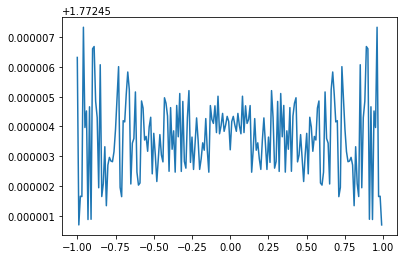

In [46]:
plt.close()
plt.plot(xl, yt / ypl)
plt.show()